In [18]:
import sqlite3

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
%load_ext autoreload
%autoreload 2

import geomtools as geo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Lecture des zones parents :

db_filename = '../data/arbres.db'
db = sqlite3.connect(db_filename)

cursor = db.cursor()

In [21]:
# get dict of all the zones
cursor.execute(""" SELECT DISTINCT code_parent, code_parent_desc FROM arbres  """)
zones_parent = { x[0]: {'name':x[1]} for x in cursor.fetchall() }

print( len(zones_parent) )

1445


In [22]:
# add infos about trees
for code_parent, infos in zones_parent.items():
    cursor.execute("""
        SELECT genre_bota, longitude, latitude FROM arbres 
        WHERE code_parent  = ?""", (code_parent, ))

    #nametuples = cursor.fetchmany(10)
    infos['arbres'] = cursor.fetchall()

In [23]:
def get_species( arbres ):
    """ retourne la liste des espèces (genre) présentes
    """
    spec = { tree[0] for tree in arbres }
    return list(spec)

In [24]:
import geojson as gj

def convert_to_geojson( polytype, coords  ):
    """ Format coords in the geoJson format (dict)
        peut être un simple ou MultiPolygon
        
        :param polytype: 'MultiPolygon'  or   'Polygon'  
        :coords: list of lists
        :return: dict
    """
    
    if polytype == 'MultiPolygon':
        geom = gj.MultiPolygon( coords )

    elif polytype == 'Polygon':
        geom = gj.Polygon( coords )
        
    return geom

In [25]:
# - loop -
iter_limit = 2000
featurelist = []
for index, (code_parent, infos) in zip( range(iter_limit), zones_parent.items()):

    points_deg = [ (tree[1], tree[2])  for tree in infos['arbres'] ]
    points_m, scale_back = geo.get_coordsarray( points_deg )

    added_points = geo.add_contourpoints( points_m, n_points = 5, r_cercle = 3 )

    all_points = np.concatenate( (added_points, points_m) )

    Rcritic = 12  # meter
    polygon = geo.alpha_shape( all_points, Rcritic  )[0]

    polytype, polycoords = geo.get_polycoords( polygon, scale_back )
    geom = convert_to_geojson( polytype, polycoords )
    featprops = {'code_parent':code_parent , 'code_parent_desc':infos['name'],
                 'genre':get_species(infos['arbres']), 
                 'numberoftrees':len(infos['arbres'])}

    feat = gj.Feature(geometry=geom, properties=featprops ) 
    featurelist.append( feat )
    
    print( index, end='\r' )
    
print(len(featurelist))

1445


In [26]:
# - save -
feature_collection = gj.FeatureCollection( featurelist )

jsontext = gj.dumps(feature_collection)

with open('../data/zoneparents.geojson', '+w') as file:
    file.write( jsontext )

## Debug zone

In [10]:
# Pick one :
code_parent, infos = list( zones_parent.items() )[187]
print( infos['name'], len(infos['arbres']), get_species(infos['arbres'])  )

Ave Randon Girard Masséna 9 ['Liquidambar']


In [11]:
points_deg = [ (tree[1], tree[2])  for tree in infos['arbres'] ]
points_m, scale_back = geo.get_coordsarray( points_deg )

added_points = geo.add_contourpoints( points_m, n_points = 5, r_cercle = 3 )

# - Alpha hub - 
all_points = np.concatenate( (added_points, points_m) )

Rcritic = 12  # m
polygon = geo.alpha_shape( all_points, Rcritic  )[0]

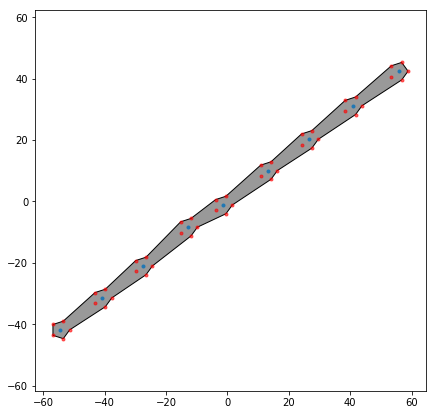

In [12]:
# plot
geo.plot_polygon( polygon  )
plt.plot( *points_m.T, '.' )
plt.plot( *added_points.T, '.r', alpha=.6 )

plt.axis('equal');

In [13]:
polytype, polycoords = geo.get_polycoords( polygon, scale_back )
geom = convert_to_geojson( polytype, polycoords )
featprops = {'code_parent':code_parent , 'code_parent_desc':infos['name'], 'genre':get_species(infos['arbres']), 
            'numberoftrees':len(infos['arbres'])}
feat = gj.Feature(geometry=geom, properties=featprops ) 

In [14]:
feat

{"geometry": {"coordinates": [[[5.7355162433766305, 45.19638033044701], [5.735415674781089, 45.1963122155782], [5.7353970323261105, 45.196286556440214], [5.735292400741649, 45.1962186501397], [5.73527375828667, 45.19619299100171], [5.73524359416088, 45.1962027919203], [5.73524359416088, 45.1962345083591], [5.73527375828667, 45.19624430927769], [5.7353668682003205, 45.1963280737976], [5.7353970323261105, 45.19633787471619], [5.73548607925084, 45.1964218478044], [5.7355162433766305, 45.19643164872299], [5.73561782671515, 45.196535413445396], [5.73564799084094, 45.19654521436399], [5.7357201577733, 45.1966004271765], [5.73575032189909, 45.19661022809509], [5.73585227131872, 45.1967013883219], [5.73588243544451, 45.19671118924049], [5.7359718507021, 45.1967927197298], [5.73600201482789, 45.19680252064839], [5.7360999984409204, 45.196891184953095], [5.7361301625667105, 45.196900985871686], [5.7362350639218, 45.196992509731196], [5.73626522804759, 45.197002310649786], [5.736283870502569, 45.

In [15]:
geom

{"coordinates": [[[5.7355162433766305, 45.19638033044701], [5.735415674781089, 45.1963122155782], [5.7353970323261105, 45.196286556440214], [5.735292400741649, 45.1962186501397], [5.73527375828667, 45.19619299100171], [5.73524359416088, 45.1962027919203], [5.73524359416088, 45.1962345083591], [5.73527375828667, 45.19624430927769], [5.7353668682003205, 45.1963280737976], [5.7353970323261105, 45.19633787471619], [5.73548607925084, 45.1964218478044], [5.7355162433766305, 45.19643164872299], [5.73561782671515, 45.196535413445396], [5.73564799084094, 45.19654521436399], [5.7357201577733, 45.1966004271765], [5.73575032189909, 45.19661022809509], [5.73585227131872, 45.1967013883219], [5.73588243544451, 45.19671118924049], [5.7359718507021, 45.1967927197298], [5.73600201482789, 45.19680252064839], [5.7360999984409204, 45.196891184953095], [5.7361301625667105, 45.196900985871686], [5.7362350639218, 45.196992509731196], [5.73626522804759, 45.197002310649786], [5.736283870502569, 45.1969766515118